# Import Data

In [173]:
import pandas as pd


# Set display options to show full timestamp
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# load CSV files
cycles_df = pd.read_csv("cycles.csv")
unit_result_df = pd.read_csv("unit_result_data.csv")

# Convert 'start_time' and 'end_time' columns to datetime in both dataframes
cycles_df['start_time'] = pd.to_datetime(cycles_df['start_time'], format='%Y-%m-%d  %H:%M:%S.%f')
cycles_df['end_time'] = pd.to_datetime(cycles_df['end_time'], format='%Y-%m-%d  %H:%M:%S.%f')

unit_result_df['start_time'] = pd.to_datetime(unit_result_df['start_time'], format='%Y-%m-%d  %H:%M:%S.%f')
unit_result_df['end_time'] = pd.to_datetime(unit_result_df['end_time'], format='%Y-%m-%d  %H:%M:%S.%f')

# Also drop columns that can be ignored, as discussed on phone call
cycles_df.drop(columns=['Unnamed: 0','station_id', 'station_name'], inplace=True)
unit_result_df.drop(columns=['Unnamed: 0','station_id', 'station_name', 'result', 'fail_reason', 'named_result'], inplace=True)


print(cycles_df)
print(unit_result_df)

# By simple inspection, we see that the dataframes are identical. Let's verify it

if cycles_df.equals(unit_result_df):
    print("The dataframes are identical.")
else:
    print("The dataframes are not identical.")
    
# Result says that dataframes are identical. So I will simply use the unit_result_df as my main dataframe

      equipment_id  serial_number      start_time        end_time  part_family         part_id
0                4           2541 2024-03-28 0... 2024-03-28 0...            6  5ccb7cb9-d5...
1                5           2541 2024-03-28 0... 2024-03-28 0...            6  6d9ffdec-a4...
2                6           2541 2024-03-28 0... 2024-03-28 0...            6  67559cf5-02...
3                5           2541 2024-03-28 0... 2024-03-28 0...            6  e5e5f234-14...
4                6           2541 2024-03-28 0... 2024-03-28 0...            6  e5e5f234-14...
...            ...            ...             ...             ...          ...             ...
9290             0           2390 2024-04-06 0... 2024-04-06 0...            1  6a231163-e5...
9291             6           2541 2024-04-06 0... 2024-04-06 0...            6  37b3940b-7e...
9292             4           2429 2024-04-06 0... 2024-04-06 0...            1  48e1ddd3-f2...
9293             0           2398 2024-04-06 0... 

# Preliminary investigation

In [174]:
# As discussed earlier, the data from both dataframes are identical. So I will continue with the
# dataframe from the unit_result_data.csv file, as it includes more columns

df = pd.read_csv("unit_result_data.csv")

# Convert 'start_time' and 'end_time' columns to datetime
df['start_time'] = pd.to_datetime(unit_result_df['start_time'], format='%Y-%m-%d  %H:%M:%S.%f')
df['end_time'] = pd.to_datetime(unit_result_df['end_time'], format='%Y-%m-%d  %H:%M:%S.%f')

# Convert datetimes to UNIX timestamp and add it to new columns
df['t1'] = (unit_result_df['start_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
df['t2'] = (unit_result_df['end_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

# Drop columns that are not required
df.drop(columns=['Unnamed: 0','station_id', 'station_name'], inplace=True)

# Check our dataframe
print(df)
    
# Create a new column, end_time - start_time, to see the time difference
df['t_diff'] = (df['end_time'] - df['start_time']).dt.total_seconds()

      equipment_id  serial_number      start_time        end_time  part_family         part_id  result fail_reason named_result             t1             t2
0                4           2541 2024-03-28 0... 2024-03-28 0...            6  5ccb7cb9-d5...     1.0         DOA         fail  1711596354610  1711596354610
1                5           2541 2024-03-28 0... 2024-03-28 0...            6  6d9ffdec-a4...     1.0         DOA         fail  1711596367165  1711596367185
2                6           2541 2024-03-28 0... 2024-03-28 0...            6  67559cf5-02...     1.0         DOA         fail  1711596376955  1711596376973
3                5           2541 2024-03-28 0... 2024-03-28 0...            6  e5e5f234-14...     1.0         DOA         fail  1711596978975  1711596979000
4                6           2541 2024-03-28 0... 2024-03-28 0...            6  e5e5f234-14...     1.0         DOA         fail  1711597063166  1711597063193
...            ...            ...             ...   

# Some simple plots

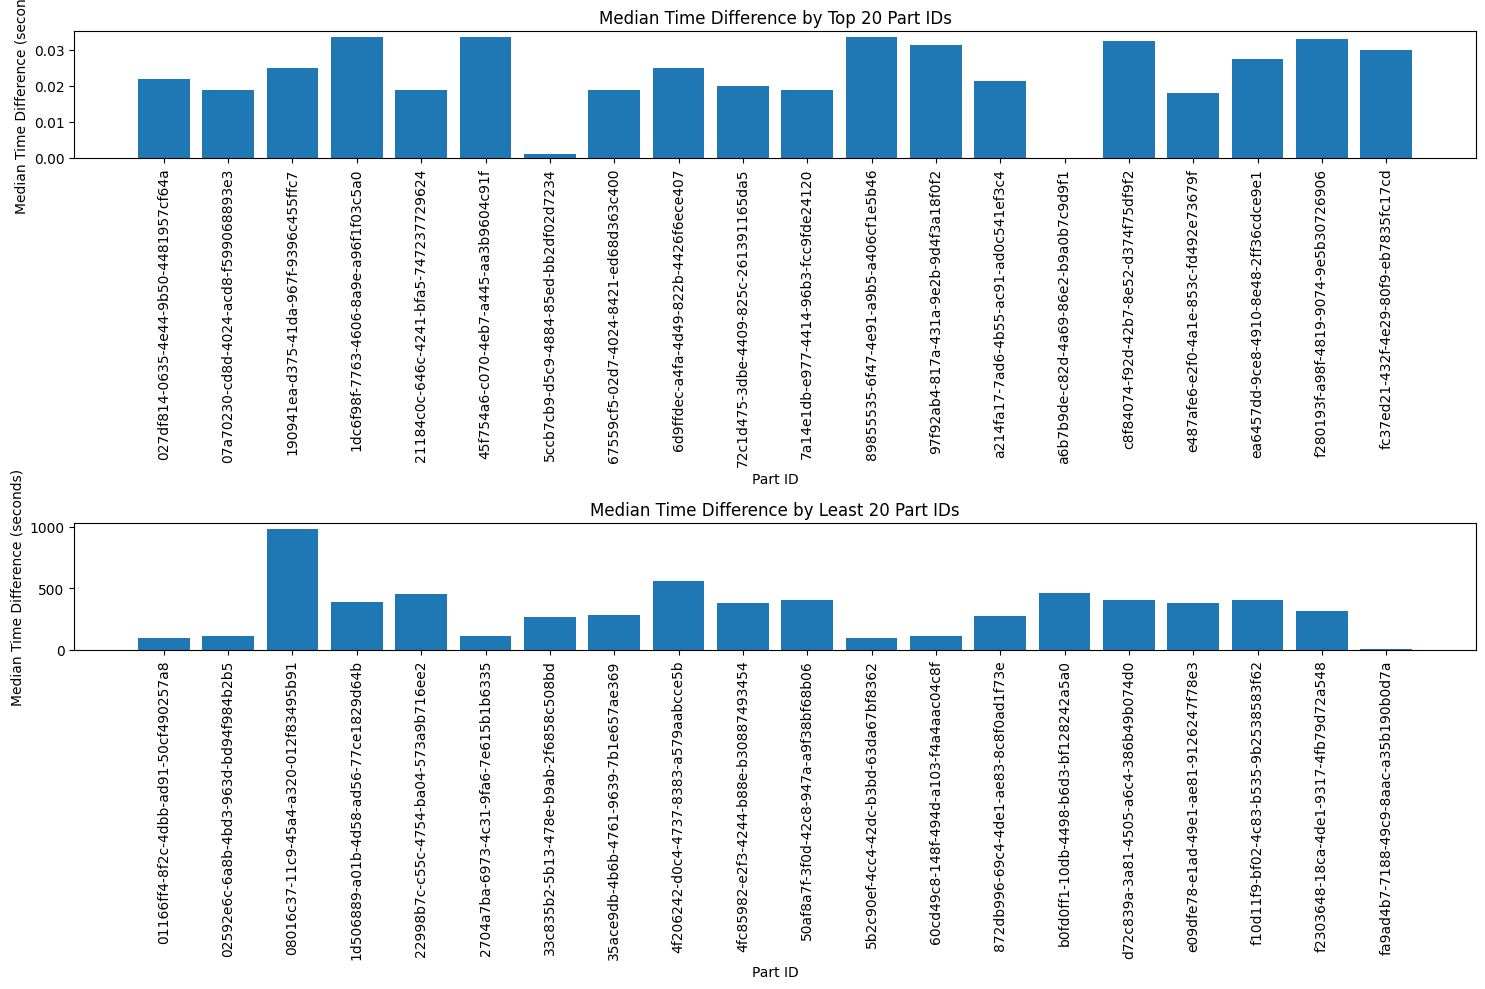

In [175]:
import matplotlib.pyplot as plt

# Choose the top N most frequent part_id values
top_n = 20

# Most frequent parts
top_part_ids = df['part_id'].value_counts().nlargest(top_n).index

# Least frequent parts
low_part_ids = df['part_id'].value_counts().nsmallest(top_n).index

# Filter the dataframe to include only rows with the top part_id values
filtered_df_largest = df[df['part_id'].isin(top_part_ids)]
filtered_df_smallest = df[df['part_id'].isin(low_part_ids)]

# Calculate median t_diff for each groupd of part_id
mean_t_diff_largest   = filtered_df_largest.groupby('part_id')['t_diff'].median()
mean_t_diff_smallest  = filtered_df_smallest.groupby('part_id')['t_diff'].median()


# Plot results
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot for most frequent part_id values
axs[0].bar(mean_t_diff_largest.index, mean_t_diff_largest)
axs[0].set_title(f'Median Time Difference by Top {top_n} Part IDs')
axs[0].set_xlabel('Part ID')
axs[0].set_ylabel('Median Time Difference (seconds)')
axs[0].tick_params(axis='x', rotation=90)

# Plot for least frequent part_id values
axs[1].bar(mean_t_diff_smallest.index, mean_t_diff_smallest)
axs[1].set_title(f'Median Time Difference by Least {top_n} Part IDs')
axs[1].set_xlabel('Part ID')
axs[1].set_ylabel('Median Time Difference (seconds)')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## By inspecting the plots, we can see that the median time difference in the most frequent part IDs is really small, whereas in least frequent part IDs the median time difference is a lot larger

# Analysis of t_diff deviation for each part ID

In [176]:
# Calculate median t_diff for each part_id
median_t_diff = df.groupby('part_id')['t_diff'].median()

# Calculate deviation of t_diff from the median for each part_id
df['t_diff_deviation'] = df.apply(lambda row: row['t_diff'] - median_t_diff[row['part_id']], axis=1)

print(df)

# Sort the dataframe, 1st by part_id and then by start_time
sorted_df = df.sort_values(by=['part_id', 't1'])

# Check our sorted dataframe
print(sorted_df)

      equipment_id  serial_number      start_time        end_time  part_family         part_id  result fail_reason named_result             t1             t2   t_diff  t_diff_deviation
0                4           2541 2024-03-28 0... 2024-03-28 0...            6  5ccb7cb9-d5...     1.0         DOA         fail  1711596354610  1711596354610    0.000         -0.0010  
1                5           2541 2024-03-28 0... 2024-03-28 0...            6  6d9ffdec-a4...     1.0         DOA         fail  1711596367165  1711596367185    0.020         -0.0050  
2                6           2541 2024-03-28 0... 2024-03-28 0...            6  67559cf5-02...     1.0         DOA         fail  1711596376955  1711596376973    0.018         -0.0010  
3                5           2541 2024-03-28 0... 2024-03-28 0...            6  e5e5f234-14...     1.0         DOA         fail  1711596978975  1711596979000    0.025         -0.0010  
4                6           2541 2024-03-28 0... 2024-03-28 0...          

# Plot trends for most frequent part IDs

C:\Users\nikmo\AppData\Local\Temp\ipykernel_13892\2341490440.py:39: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(start=start_time, periods=len(t_diff_values), freq='S')


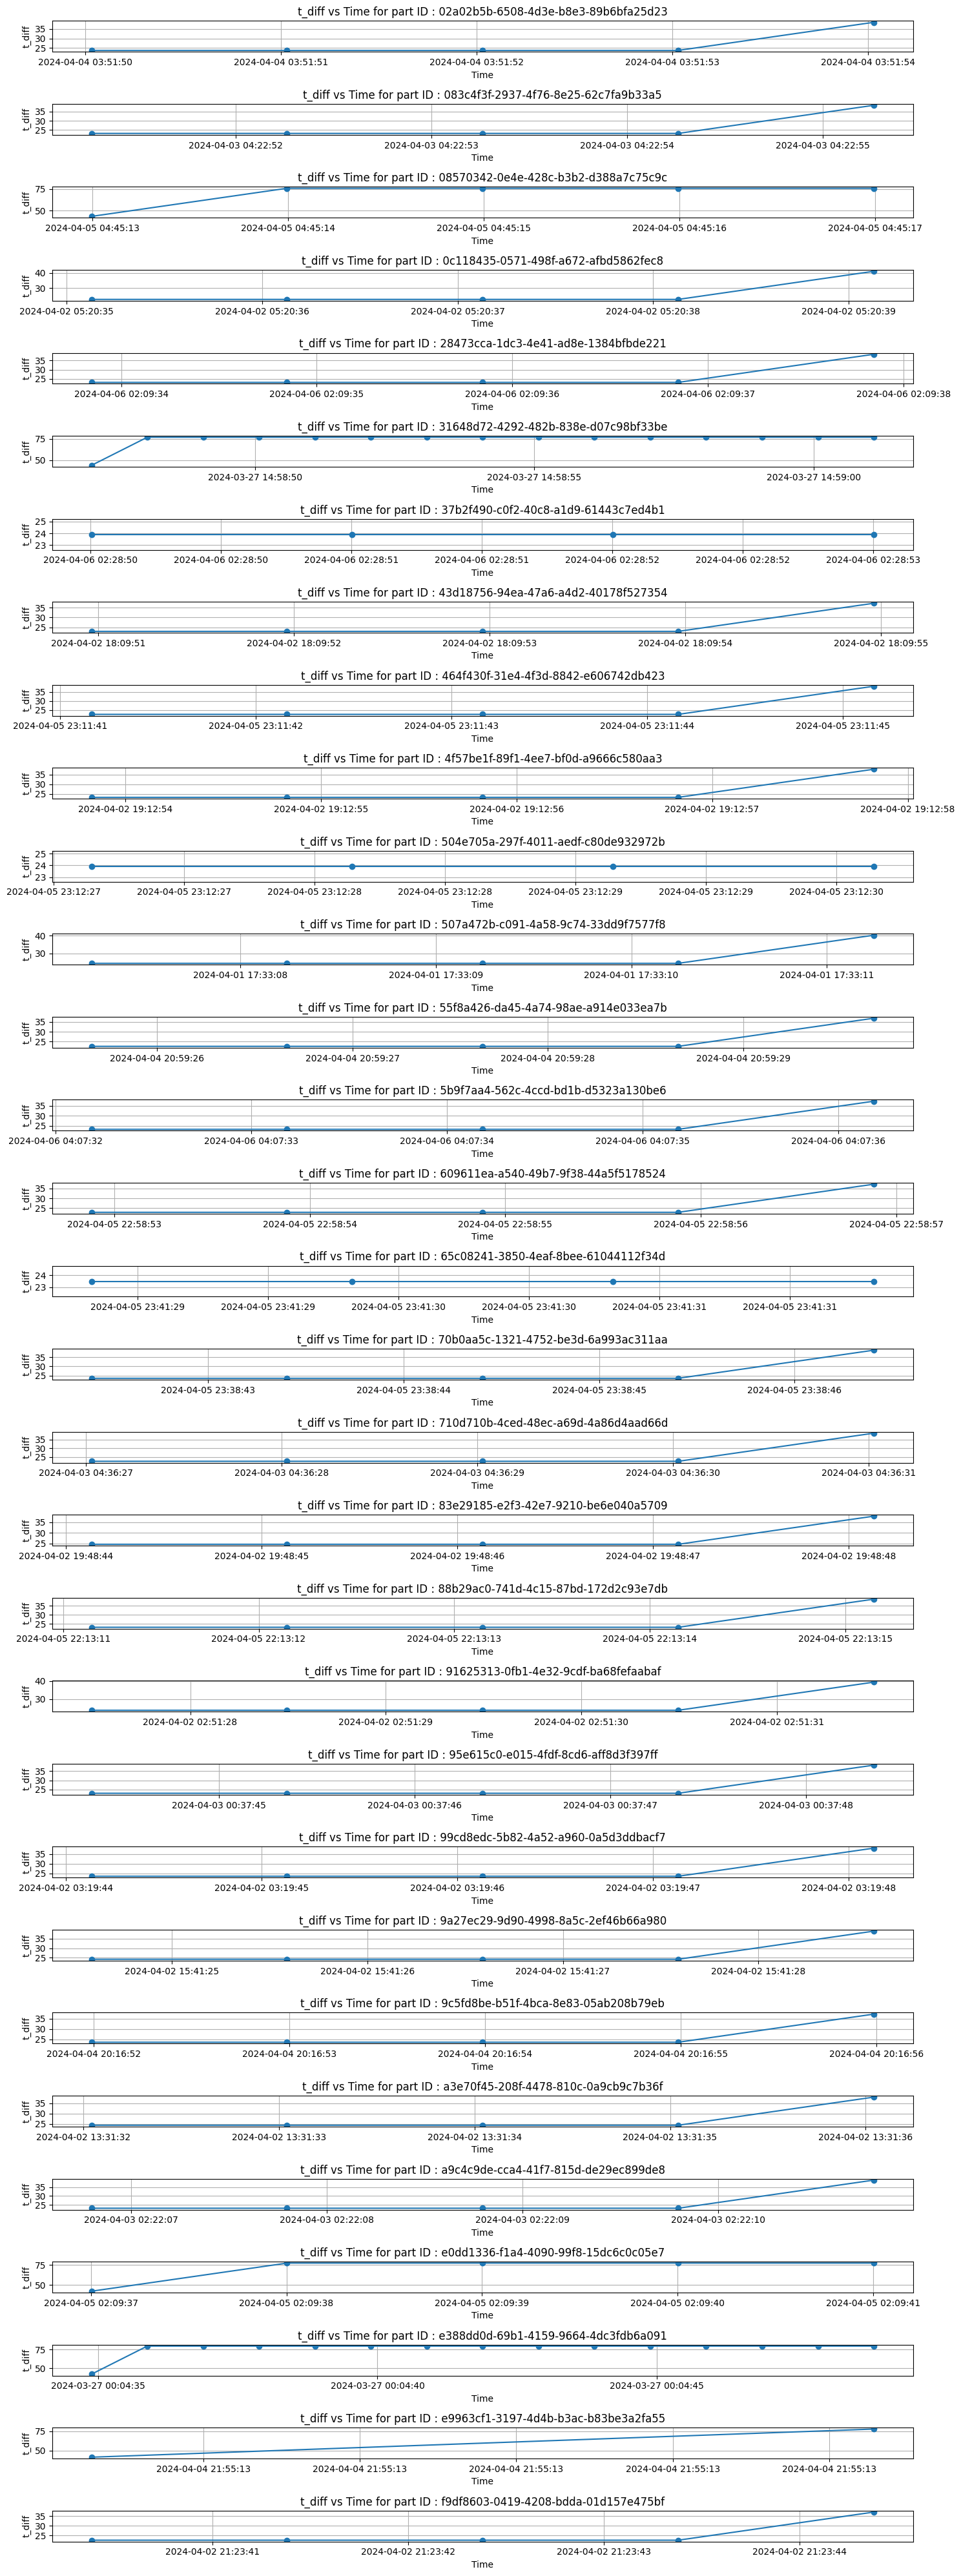

In [223]:
import matplotlib.dates as mdates

# We can't plot all the trends as there are many IDs and the figure would look messy.

# Instead we will focus on a few.

# E.g., get the top 65 more frequent IDs
top_n = 100
top_part_ids = sorted_df['part_id'].value_counts().nlargest(top_n).index

# Sort them on ID
filtered_df_largest = sorted_df[sorted_df['part_id'].isin(top_part_ids)]

# Create a temporary dataframe, filter the most frequent dataframe to keep IDs that have at least one Success code (0)
tempdf = filtered_df_largest[filtered_df_largest['result'] == 0]

# Get that unique IDs in a list
unique_part_ids = tempdf['part_id'].unique().tolist()

# How many unique IDs did we get?
num_of_uniques = len(unique_part_ids)

fig, axs = plt.subplots(num_of_uniques, 1, figsize=(15, 40))

# For each unique ID, create a subplot
for i, part_id in enumerate(unique_part_ids):
    plot_df = tempdf[tempdf['part_id'] == part_id]
    
    # Extract start_time of the first row
    start_time = plot_df.iloc[0]['start_time']
    
    # Extract end_time of the last row
    end_time = plot_df.iloc[-1]['end_time']
    
    # Extract t_diff values
    t_diff_values = plot_df['t_diff']
    
    # Create time range for x-axis (in seconds)
    time_range = pd.date_range(start=start_time, periods=len(t_diff_values), freq='S')
    
    # Plot
    axs[i].plot(time_range, t_diff_values, marker='o', linestyle='-')
    axs[i].set_title(f't_diff vs Time for part ID : {part_id}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('t_diff')
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))  # Set date format
    axs[i].grid(True)

plt.tight_layout()
plt.show()
    

## What we notice is that cycles tend to increase in duration, as time progresses.

## After the analysis of data, we can upload the dataframe to our database

# Check for NaNs on important columns

In [228]:
result_nan1 = sorted_df['result'].isnull().values.any()
result_nan2 = sorted_df['start_time'].isnull().values.any()
result_nan3 = sorted_df['end_time'].isnull().values.any()
result_nan4 = sorted_df['part_id'].isnull().values.any()

print(result_nan1)
print(result_nan2)
print(result_nan3)
print(result_nan4)

False
False
False
